#  H&M E-commerce Data - Exploratory Data Analysis

## Business Context
This notebook performs comprehensive exploratory data analysis on H&M's fashion retail dataset containing:
- **31.8M transactions** over 2 years (2018-2020)
- **1.37M customers** with demographic profiles
- **105K products** with detailed attributes

## Objectives
1. Understand data quality and structure
2. Analyze customer behavior and preferences
3. Identify product trends and patterns
4. Discover temporal patterns and seasonality
5. Prepare insights for feature engineering
6. Establish baseline metrics for ML models

## Analysis Sections
1. Data Overview & Quality
2. Customer Analysis
3. Product Analysis
4. Transaction Patterns
5. Customer Lifetime Value
6. Time-Series Deep Dive
7. Correlations & Relationships
8. ML Preparation Insights

---

In [7]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')


#Add scripts to path
sys.path.append('../scripts')



# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import(
    col , count, countDistinct, sum as spark_sum, avg, stddev, min as spark_min, 
    max as spark_max, year , month , dayofmonth, dayofweek, weekofyear, datediff, lit, when,
    desc, asc, collect_list, approx_count_distinct

)

from pyspark.sql.window import Window

#Data visualization

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


#Data analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

#our custom modules
from etl.spark_config import get_spark_session, stop_spark_session, PATHS
from etl.extract import DataExtractor
from etl.validate_data import DataValidator


# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

OUTPUT_DIR="../outputs/eda_charts"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [8]:
spark = get_spark_session("EDA_Analysis")

🔧 Detected 6 CPU cores
 Setting default parallelism to 12
SparkSession created: EDA_Analysis
Spark UI available at: http://localhost:4040
Spark Version: 3.5.0


In [10]:
extractor=DataExtractor(spark, PATHS['raw_data'])
articles_df, customers_df, transactions_df=extractor.load_all()

 Data Extractor initialized
 Raw data path: /media/dk/Data/HM_Ecommerce_Project/raw_data
STARTING DATA EXTRACTION PIPELINE
 LOADING ARTICLES (Product Catalog)


 Loaded successfully in 5.88 seconds
 Rows: 105,542
 Columns: 25
 Partitions: 9
 Cached in memory: Yes


 Loaded successfully in 2.45 seconds
 Rows: 1,371,980
 Columns: 7
 Partitions: 12
 Cached in memory: Yes


 Loaded successfully in 29.36 seconds
 Rows: 31,788,324
 Columns: 5
 Partitions: 26
 Cached in memory: No (too large)
 ALL DATA LOADED SUCCESSFULLY
  Total loading time: 47.80 seconds


 Total rows: 33,265,846


---

# 1 DATA OVERVIEW & QUALITY

Understanding the foundation of our data before diving into analysis.

In [11]:
datasets = {
    "Articles": articles_df,
    "Customers": customers_df,
    "Transactions": transactions_df
}

In [13]:
articles_df.printSchema()

root
 |-- article_id: integer (nullable = true)
 |-- product_code: integer (nullable = true)
 |-- prod_name: string (nullable = true)
 |-- product_type_no: integer (nullable = true)
 |-- product_type_name: string (nullable = true)
 |-- product_group_name: string (nullable = true)
 |-- graphical_appearance_no: integer (nullable = true)
 |-- graphical_appearance_name: string (nullable = true)
 |-- colour_group_code: integer (nullable = true)
 |-- colour_group_name: string (nullable = true)
 |-- perceived_colour_value_id: integer (nullable = true)
 |-- perceived_colour_value_name: string (nullable = true)
 |-- perceived_colour_master_id: integer (nullable = true)
 |-- perceived_colour_master_name: string (nullable = true)
 |-- department_no: integer (nullable = true)
 |-- department_name: string (nullable = true)
 |-- index_code: string (nullable = true)
 |-- index_name: string (nullable = true)
 |-- index_group_no: integer (nullable = true)
 |-- index_group_name: string (nullable = true)

In [14]:
customers_df.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- FN: double (nullable = true)
 |-- Active: double (nullable = true)
 |-- club_member_status: string (nullable = true)
 |-- fashion_news_frequency: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- postal_code: string (nullable = true)



In [15]:
transactions_df.printSchema()

root
 |-- t_dat: date (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- article_id: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- sales_channel_id: integer (nullable = true)



In [20]:
#analyze missing values

def analyze_missing_values(df, dataset_name):
    total_rows=df.count()

    missing_data=[]
    for col_name in df.columns:
        null_count=df.filter(col(col_name).isNull()).count()
        if null_count > 0:
            missing_pct=(null_count / total_rows) * 100
            missing_data.append({
                "Column ": col_name,
                "Missing Count " : f"{null_count:,}",
                "Missing % ": f"{missing_pct:.2f} %"
            })
        
    if missing_data:
        print(f"\n {dataset_name} :")
        missing_df= pd.DataFrame(missing_data)
        print(missing_df.to_string(index=False))
    else:
        print(f"\n {dataset_name} :  No missing values")

In [21]:
analyze_missing_values(articles_df, "Articles")


 Articles :
    Column  Missing Count  Missing % 
detail_desc            416     0.39 %


In [22]:
analyze_missing_values(customers_df, "Customers")


 Customers :
               Column  Missing Count  Missing % 
                    FN        895,050    65.24 %
                Active        907,576    66.15 %
    club_member_status          6,062     0.44 %
fashion_news_frequency         16,009     1.17 %
                   age         15,861     1.16 %


In [23]:
analyze_missing_values(transactions_df, "Transactions")


 Transactions :  No missing values



 Creating missing values visualization...


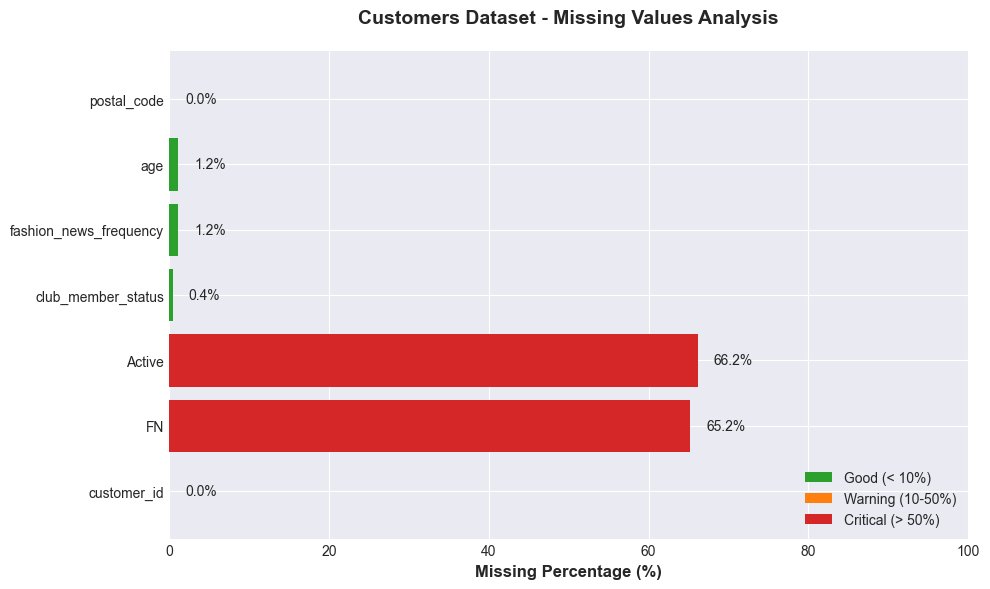

 Saved: ../outputs/eda_charts/01_missing_values.png


In [24]:
# Visualize missing values for Customers (the one with missing data)
print("\n Creating missing values visualization...")

# Calculate missing percentages for customers
customer_missing = []
total_customers = customers_df.count()

for col_name in customers_df.columns:
    null_count = customers_df.filter(col(col_name).isNull()).count()
    missing_pct = (null_count / total_customers) * 100
    customer_missing.append({
        "Column": col_name,
        "Missing %": missing_pct
    })

customer_missing_df = pd.DataFrame(customer_missing)

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#d62728' if x > 50 else '#ff7f0e' if x > 10 else '#2ca02c' 
          for x in customer_missing_df['Missing %']]

bars = ax.barh(customer_missing_df['Column'], customer_missing_df['Missing %'], color=colors)

ax.set_xlabel('Missing Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Customers Dataset - Missing Values Analysis', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 100)

# Add percentage labels
for i, (col, pct) in enumerate(zip(customer_missing_df['Column'], customer_missing_df['Missing %'])):
    ax.text(pct + 2, i, f'{pct:.1f}%', va='center', fontsize=10)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ca02c', label='Good (< 10%)'),
    Patch(facecolor='#ff7f0e', label='Warning (10-50%)'),
    Patch(facecolor='#d62728', label='Critical (> 50%)')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/01_missing_values.png", dpi=300, bbox_inches='tight')
plt.show()

print(f" Saved: {OUTPUT_DIR}/01_missing_values.png")

---

# 2 CUSTOMER ANALYSIS

Understanding our customer base: demographics, behavior, and engagement patterns.

## Key Questions:
- What's the age distribution of our customers?
- How engaged are customers (club membership)?
- What are their communication preferences?
- Are there distinct customer segments visible?